In [159]:
%matplotlib inline
from matplotlib import pylab as plt

import ase
from ase.io import read
from ase.visualize import view
import numpy as np


from rascal.representations import SphericalInvariants
from rascal.models import gaptools
from rascal.models.asemd import ASEMLCalculator
from rascal.utils import dump_obj, load_obj, print_score
from rascal.models import gaptools, KRR

from tools.download import download_url
from tools.utils import fix_frames, train_test_split, filter_frames, get_config_type

For this exercise we will use the [Silicon dataset](https://doi.org/10.1103/PhysRevX.8.041048) published in

```
Machine Learning a General-Purpose Interatomic Potential for Silicon
Albert P. Bartók, James Kermode, Noam Bernstein, and Gábor Csányi
Phys. Rev. X 8, 041048 – Published 14 December 2018
```

In [3]:
# path to the dataset
url = "https://github.com/libAtoms/silicon-testing-framework/raw/master/models/GAP/gp_iter6_sparse9k.xml.xyz"

structures_fn = download_url(url, './')
structures_fn

Using existing file gp_iter6_sparse9k.xml.xyz


'./gp_iter6_sparse9k.xml.xyz'

# Build a Force Field

In [180]:


# load the structures
frames = fix_frames(read(structures_fn,':'))
# and extract the first one because it coresponds to an isolated configuration
# used to convert total energies into formation energies
isolated_atom = frames[0]
frames = frames[1:]

global_species = [14]

# Isolated atom contributions
energy_baseline = {
    14: isolated_atom.info['dft_energy'],
}

print(get_config_type(frames))

{'interstitial', 'bcc', 'sp', 'sp2', 'divacancy', 'surface_110', 'amorph', 'sh', 'crack_110_1-10', 'liq', 'surface_111_pandey', 'surface_111', 'surface_001', 'surface_111_3x3_das', 'crack_111_1-10', 'screw_disloc', 'decohesion', 'fcc', 'hcp', '111adatom', 'bt', 'bc8', 'st12', 'vacancy', 'dia', 'hex_diamond'}


In [182]:
# remove some types of configurations to lower the memory requirements of the exercise 
excludes = ['amorph', 'crack_110_1-10', 'crack_111_1-10', 'decohesion', 'interstitial','divacancy', 'liq', 'screw_disloc','surface_001', 'surface_110', 'surface_111', 'surface_111_3x3_das', 'surface_111_pandey', 'vacancy', 'st12', 
#'sh'
# 'sp', 'sp2'
# 'sh',
# 'sp', 'sp2', '111adatom'
#'sp', 'sp2', 'sh', 
]


frames = filter_frames(frames, excludes)
# Total number of structure to load
N = len(frames)
# Number of structure to train the model with
n_train = int(0.7*N)

print(get_config_type(frames))
N, n_train

{'fcc', 'hcp', '111adatom', 'bt', 'bcc', 'bc8', 'dia', 'hex_diamond'}


(1190, 833)

In [183]:
ids = np.arange(N)
np.random.seed(10)
np.random.shuffle(ids)

# split the structures in 2 sets
frames_train, y_train, f_train, frames_test, y_test, f_test = train_test_split(ids, n_train, frames)



In [184]:
# define the parameters of the spherical expansion
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=5, 
              max_radial=8, 
              max_angular=6, 
              gaussian_sigma_constant=0.4,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.5,
              normalize=True,
              radial_basis="GTO",
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              optimization={"Spline":{"accuracy":1e-6}}
              )

soap = SphericalInvariants(**hypers)


In [185]:
# compute the representation of all the structures
soap, feature_list = gaptools.calculate_representation(frames, hypers)

In [186]:
n_features = 200
sparcified_hypers = gaptools.sparsify_features(soap, feature_list, n_features, selection_type="FPS")

In [187]:
# compute the sparsified representation
soap, feature_list = gaptools.calculate_representation(frames, sparcified_hypers)

In [188]:
# identify representative configuration within the dataset to use as basis
# in the GAP model 
n_sparse = {14: 1000}
X_sparse = gaptools.sparsify_environments(soap, feature_list, n_sparse, selection_type="FPS")

In [189]:
# Compute the kernel elements and their derivatives
(k_obj, K_sparse_sparse, K_full_sparse, K_grad_full_sparse) = gaptools.compute_kernels(
    soap,
    feature_list,
    X_sparse,
    soap_power=2,
)

Compute kernel gradients:   0%|          | 0/1190 [00:00<?, ?it/s]

In [190]:
# split the kernel matrices into a trainig and testing set
natoms = [len(frame) for frame in frames]
K_train_sparse, K_grad_train_sparse = gaptools.extract_kernel_indices(
    ids[:n_train], K_full_sparse, K_grad_full_sparse, natoms=natoms
)
K_test_sparse, K_grad_test_sparse = gaptools.extract_kernel_indices(
    ids[n_train:], K_full_sparse, K_grad_full_sparse, natoms=natoms
)

In [191]:
# train a gap model
weights = gaptools.fit_gap_simple(
    frames_train,
    K_sparse_sparse,
    y_train,
    K_train_sparse,
    energy_regularizer_peratom=1E-3,
    forces=f_train,
    kernel_gradients_sparse=K_grad_train_sparse,
    energy_atom_contributions=energy_baseline,
    force_regularizer=1E-2,
    solver="RKHS-QR"
)

In [192]:
model = KRR(weights, k_obj, X_sparse, energy_baseline,
            description="GAP MLIP for solid Silicon")
dump_obj('silicon_model.json', model)

Error statistics on the energy per atom:
MAE=1.06e-03 RMSE=2.67e-03 SUP=2.96e-02 R2=1.00e+00 CORR=1.00e+00


Text(0, 0.5, 'reference energies [eV/atom]')

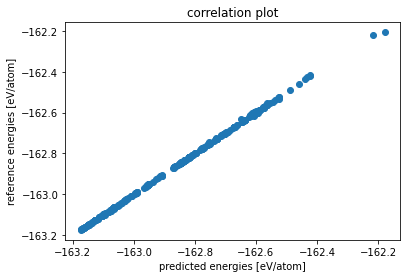

In [193]:
# basic assessement of the quality of the trained model
y_pred = model.predict(frames_test, KNM=K_test_sparse)
f_pred = model.predict_forces(frames_test, KNM=K_grad_test_sparse)
natoms = np.array([len(frame) for frame in frames_test])

print('Error statistics on the energy per atom:')
print_score(y_pred/natoms, y_test/natoms)
plt.plot(y_test/natoms, y_pred/natoms, 'o')
plt.title("correlation plot")
plt.xlabel("predicted energies [eV/atom]")
plt.ylabel("reference energies [eV/atom]")

Error statistics on the forces:
MAE=9.93e-03 RMSE=2.11e-02 SUP=1.52e+00 R2=9.97e-01 CORR=9.99e-01


Text(0, 0.5, 'reference forces [eV/$\\AA$]')

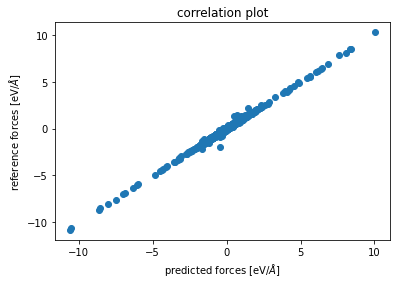

In [194]:
print('Error statistics on the forces:')
print_score(f_pred.flatten(), f_test.flatten())
plt.plot(f_pred.flatten(), f_test.flatten(), 'o')
plt.title("correlation plot")
plt.xlabel(r"predicted forces [eV/$\AA$]")
plt.ylabel(r"reference forces [eV/$\AA$]")

# Test the model on physical properties

In [195]:
# you can load the previously trained model
model = load_obj('silicon_model.json')

## Check the dimer curve

In [196]:
pairs = [[14,14]]
ndists = 40 #number of distances to look at
dists = np.linspace(1.5,4.9,ndists) #distance list, can be changed

frames = []
for p in pairs:
    for d in dists:
        #using ase we can create the cell and place the atoms
        atoms = ase.Atoms(numbers=p,pbc=False,cell=np.eye(3)*10,positions=[[0,0,0],[d,0,0]])
        frames.append(atoms)
soap = model.get_representation_calculator()
X = soap.transform(frames)
e_pairs = model.predict(X)
e_pairs -= e_pairs.mean()



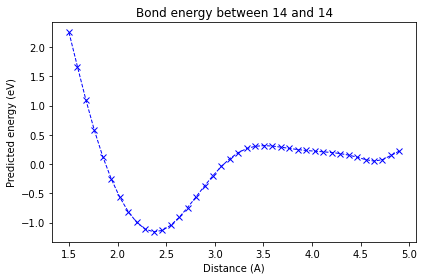

In [197]:
for pair_to_plot in pairs:
    i = pairs.index(pair_to_plot)
    fig, ax = plt.subplots()
    ax.plot(dists,e_pairs[i*ndists:(i+1)*ndists],'--xb',linewidth=1)
    ax.set_xlabel('Distance (A)')
    ax.set_ylabel('Predicted energy (eV)')
    ax.set_title('Bond energy between {} and {}'.format(*pair_to_plot))
    plt.tight_layout()
    plt.show()

## Compute the eqution of state of the diamond and $\beta$-$S_n$ phases of silicon and the stiffness tensor of the diamond phase

In [5]:
from rascal.models.asemd import ASEMLCalculator

from tools.lattice_cubic import do_lattice as do_cubic
from tools.lattice_tetragonal import do_lattice as do_tetragonal
from tools.utils import dft_ref

from ase.io.trajectory import Trajectory
from ase.io import read
from ase.lattice.cubic import Diamond



### The diamond phase

In [6]:
calc = ASEMLCalculator(model, model.get_representation_calculator())
a0 = (20.0*8)**(1.0/3.0) # initial guess at lattice constant, cell will be relaxed below

# set up the a
atoms = Diamond(symbol='Si', latticeconstant=a0)
atoms.set_calculator(calc)
c11, c12, c44, E_vs_V = do_cubic(atoms, elastic=True)
a0 = atoms.cell[0,0] # save lattice constant after relaxation

PreconLBFGS:   0  22:29:06    -1305.407684       0.0000       0.0099
PreconLBFGS:   1  22:29:06    -1305.421870       0.0000       0.0001


/home/musil/miniconda/envs/mlip_workshop/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.reciprocal()
  warnings.warn(warning)


relaxed bulk
8
Lattice="5.4618998363920825 0.0 0.0 0.0 5.4618998363920825 0.0 0.0 0.0 5.4618998363920825" Properties=species:S:1:pos:R:3:forces:R:3 energy=-1305.4218700547265 stress="5.149656451751183e-05 0.0 1.72155838059761e-35 0.0 5.149656451751183e-05 1.72155838059761e-35 1.72155838059761e-35 1.72155838059761e-35 5.149656451751178e-05" free_energy=-1305.4218700547265 pbc="T T T"
Si       0.00000000      -0.00000000      -0.00000000      -0.00000000      -0.00000000       0.00000000
Si       1.36547496       1.36547496       1.36547496      -0.00000000      -0.00000000       0.00000000
Si       2.73094992       2.73094992      -0.00000000       0.00000000       0.00000000      -0.00000000
Si       4.09642488       4.09642488       1.36547496       0.00000000       0.00000000       0.00000000
Si       2.73094992      -0.00000000       2.73094992       0.00000000      -0.00000000       0.00000000
Si       4.09642488       1.36547496       4.09642488       0.00000000      -0.00000000  

In [7]:
ml_pred = {}
ml_pred['diamond'] = {'a0': a0, 'c11': c11, 'c12': c12, 'c44': c44, 
                  'bulk_modulus': (c11+2.0*c12)/3.0, 'E_vs_V': E_vs_V }

### The $\beta$-$S_n$ phase

In [8]:
atoms = ase.Atoms([14] * 2, positions=[(0.0, -0.25, -0.069), (0.0, 0.25, 0.069)], 
       cell=[ [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.5, 0.5, 0.276]], pbc=(1,1,1))

cell = atoms.get_cell()
cell *= (20.0*2/atoms.get_volume())**(1.0/3.0)
atoms.set_cell(cell, scale_atoms=True)
atoms.set_calculator(calc)

E_vs_V = do_tetragonal(atoms, elastic=False)

# dictionary of computed properties - this is output of this test, to
#   be compared with other models
ml_pred['beta-Sn'] = {'E_vs_V': E_vs_V }

PreconLBFGS:   0  22:29:18     -325.208934       0.0000       0.0890
PreconLBFGS:   1  22:29:18     -325.378323       0.0000       0.0780
PreconLBFGS:   2  22:29:18     -325.470502       0.0000       0.0766
PreconLBFGS:   3  22:29:18     -325.589161       0.0000       0.0652
PreconLBFGS:   4  22:29:18     -325.646963       0.0000       0.0524
PreconLBFGS:   5  22:29:18     -325.686138       0.0000       0.0345
PreconLBFGS:   6  22:29:18     -325.711706       0.0000       0.0095
PreconLBFGS:   7  22:29:18     -325.713023       0.0000       0.0015
PreconLBFGS:   8  22:29:19     -325.713316       0.0000       0.0010
      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 22:29:19     -325.593773*       0.0624
FIRE:    1 22:29:19     -325.593829*       0.0574
FIRE:    2 22:29:19     -325.593924*       0.0478
FIRE:    3 22:29:19     -325.594027*       0.0342
FIRE:    4 22:29:19     -325.594106*       0.0178
FIRE:    5 22:29:19     -325.59

### Compare our MLIP with the DFT reference

In [9]:
print('Relative error on several structural properties of the diamond phase of silicon w.r.t. the DFT reference:')
for (k,ref) in dft_ref['diamond'].items():
    pred = ml_pred['diamond'][k]
    if k == 'E_vs_V': continue
    print(f"    {k}: {(ref-pred)/ref*100} %")

Relative error on several structural properties of the diamond phase of silicon w.r.t. the DFT reference:
    bulk_modulus: 3.9720347949153982 %
    c12: -1.2652753340635394 %
    c11: 7.8157211290384305 %
    c44: 15.848109159821208 %
    a0: -0.01608367018659827 %


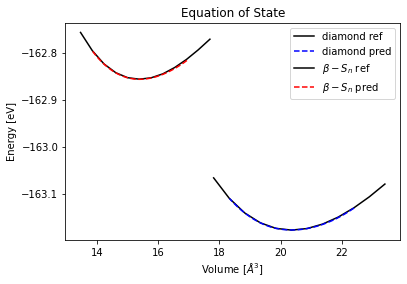

In [10]:
aa = np.array(dft_ref['diamond']['E_vs_V'],dtype=object)
bb = np.array(ml_pred['diamond']['E_vs_V'],dtype=object)
plt.plot(aa[:,0],aa[:,1],'-k',label='diamond ref')
plt.plot(bb[:,0],bb[:,1],'--b',label='diamond pred')

aa = np.array(dft_ref['beta-Sn']['E_vs_V'],dtype=object)
bb = np.array(ml_pred['beta-Sn']['E_vs_V'],dtype=object)
plt.plot(aa[:,0],aa[:,1],'-k',label=r'$\beta-S_n$ ref')
plt.plot(bb[:,0],bb[:,1],'--r',label=r'$\beta-S_n$ pred')
plt.title('Equation of State')
plt.ylabel('Energy [eV]')
plt.xlabel(r'Volume [$\AA^3$]')
plt.legend()

# Use it to run a MD simulation

In [103]:
from ase.md import MDLogger
from ase.md.langevin import Langevin
from ase import units
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution

In [113]:
from rascal.models.asemd import ASEMLCalculator

In [105]:
# Use the model loaded above
soap = model.get_representation_calculator()
calc = ASEMLCalculator(model, soap)

In [106]:
log_fn = '/tmp/md.log'
filename = '/tmp/md.traj'

T = 500

In [109]:
%%time

atoms = read(structures_fn, 50)

MaxwellBoltzmannDistribution(atoms, T* units.kB)

atoms.set_calculator(calc)

traj = Trajectory(filename, mode='w', atoms=atoms, master=None)

dyn = Langevin(atoms, 0.5 * units.fs, temperature_K= T, friction=0.002)

dyn.attach(MDLogger(dyn, atoms, log_fn, header=True, stress=False,
           peratom=False, mode="w"), interval=50)

dyn.attach(traj.write, interval=10)

dyn.run(1000)

/home/musil/miniconda/envs/mlip_workshop/lib/python3.9/site-packages/ase/md/md.py:48: FutureWarning: Specify the temperature in K using the 'temperature_K' argument
  warnings.warn(FutureWarning(w))


CPU times: user 6min 56s, sys: 19min 29s, total: 26min 25s
Wall time: 1min 39s


True

Uncomment and run the cell below to examine the trajectory using the ASE viewer:

In [110]:
view(read(filename,':'), viewer='ngl')